In [1]:
import sys
import importlib

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

# Constants

In [2]:
collimator = dict(distance=250, angle=6, direction=60, number=306, todetector=4.37, diameter=1.5, interval=0.2, thickness=35)
detector = dict(number=128, width=4.0625, length=520, depth=9.5)
image = dict(pixels=128, width=4.0625)

In [3]:
x_pixels = np.arange(-image['pixels'] / 2 * image['width'] + image['width'] / 2, image['pixels'] / 2 * image['width'] + image['width'] / 2, image['width'])

In [4]:
X_pixels, Y_pixels = np.meshgrid(x_pixels, x_pixels)

# Transformation matrix

In [5]:
def trans_matrix(method='delta'):
    if method == 'delta':
        matrix = np.empty((detector['number'] * collimator['direction'], image['pixels'] ** 2))#.astype(np.float32)
        for i in range(collimator['direction']):
            theta = i * collimator['angle'] / 180 * np.pi + 1e-8
            m = np.zeros((detector['number'], image['pixels'] ** 2))
            k = np.tan(theta)
            t_c = np.arange(-detector['number'] / 2 * detector['width'], detector['number'] / 2 * detector['width'] + 1e-8, detector['width'])
            x_o = np.cos(theta) * (collimator['distance'] + collimator['todetector'] + collimator['thickness'])
            y_o = np.sin(theta) * (collimator['distance'] + collimator['todetector'] + collimator['thickness'])
            x_c = np.cos(theta + np.pi / 2) * t_c + x_o
            y_c = np.sin(theta + np.pi / 2) * t_c + y_o
            b = y_c - k * x_c
            slit = np.digitize(Y_pixels.flatten() - k * X_pixels.flatten(), b) - 1
            # slit = slit[(slit >= 0) & (slit < detector['number'])]
            # idx, count = np.unique(slit, return_counts=True)
            for j, s in enumerate(slit):
                if s >= 0 and s < detector['number']:
                    m[s, j] = 1
            matrix[detector['number'] * i:detector['number'] * (i+1)] = m
    return matrix

In [6]:
m = trans_matrix()

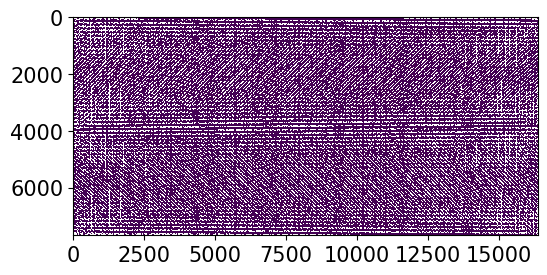

In [7]:
plt.imshow(m, norm=LogNorm(vmin=0.5, vmax=2.0))
plt.show()

# ML-EM reconstruction

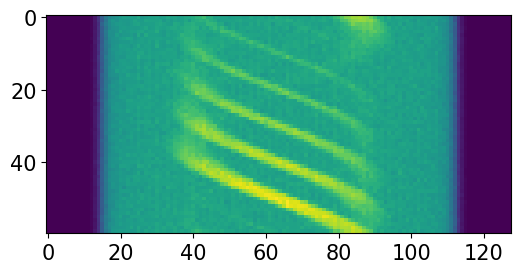

In [8]:
p = np.fromfile('Proj_1e7Counts', dtype=np.float32)

plt.imshow(p.reshape((collimator['direction'], image['pixels'])))
plt.show()

In [9]:
f = np.full(image['pixels'] ** 2, p.sum() / m.sum()).astype(np.float32)
f_list = [f]
d_list = []

for i in tqdm(range(200)):
    f_t = f_list[-1] / m.sum(axis=0) * (m.T @ (p / (m @ f_list[-1])))
    f_list.append(f_t)
    d_list.append(np.abs(f_list[-2] - f_list[-1]).max())
    if d_list[-1] < 1e-3:
        break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.13it/s]


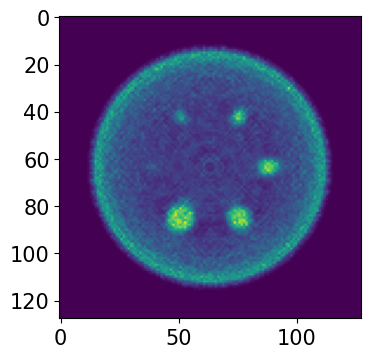

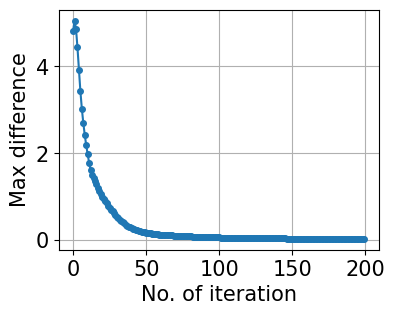

In [10]:
gray = f_list[-1].reshape((image['pixels'], image['pixels']))
plt.imshow(gray)
plt.show()

fig = plt.figure(figsize=(4, 3))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
# ax.scatter(np.arange(len(d_list)), d_list, s=2.0)
ax.plot(np.arange(len(d_list)), d_list, 'o-', markersize=4.0)
ax.grid()
ax.set_xlabel('No. of iteration')
ax.set_ylabel('Max difference')

plt.show()

In [11]:
gray.astype('float32').tofile('result')

# OS-EM reconstruction

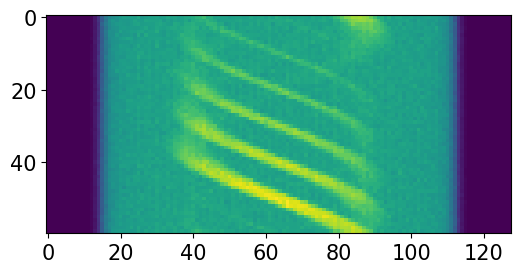

In [12]:
p = np.fromfile('Proj_1e7Counts', dtype=np.float32)

plt.imshow(p.reshape((collimator['direction'], image['pixels'])))
plt.show()

In [13]:
L_list = np.array([1, 2, 4, 6, 10, 15, 30])
L = L_list[3]

f = np.full(image['pixels'] ** 2, p.sum() / m.sum())
f_list = [f]
d_list = []
tiny = np.finfo(np.float32).tiny
D = L * detector['number']

for i in tqdm(range(50)):
    for j in range(collimator['direction'] // L):
        f_t = f_list[-1] / (m[D*j:D*(j+1), :].sum(axis=0) + tiny) * (m[D*j:D*(j+1), :].T @ (p[D*j:D*(j+1)] / (m[D*j:D*(j+1), :] @ f_list[-1] + tiny)))
        f_list.append(f_t)
        d_list.append(np.abs(f_list[-2] - f_list[-1]).max())
        # if d_list[-1] < 1e-3:
        #     break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.12it/s]


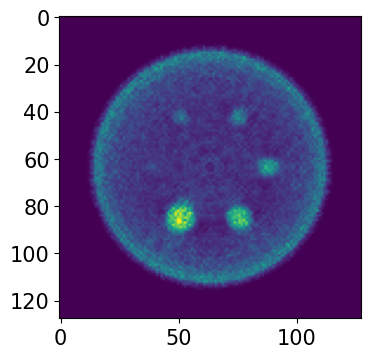

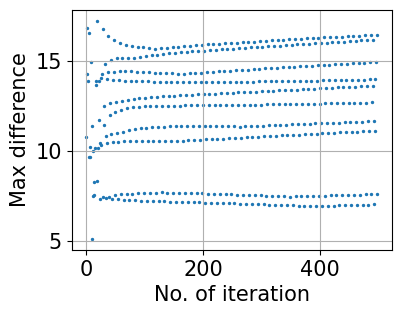

In [14]:
gray = f_list[-1].reshape((image['pixels'], image['pixels']))
plt.imshow(gray)
plt.show()

fig = plt.figure(figsize=(4, 3))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(np.arange(len(d_list)), d_list, s=2.0)
# ax.plot(np.arange(len(d_list)), d_list, 'o-', markersize=4.0)
ax.grid()
ax.set_xlabel('No. of iteration')
ax.set_ylabel('Max difference')

plt.show()

In [15]:
gray.astype('float32').tofile('result')